# Calculate isostatic geoid anomaly assuming Airy isostasy using 2 methods


This notebook calculates the geoid anomaly caused by isostatic compensation under the Airy hypothesis. Two methods are presented: point-by-point method and a tesseroid-based gravitational potential model.

The geoid anomaly caused by isostatic compensation:

$$
\Delta N = -\frac{2\pi G}{g_r} \int_{-\infty}^{z_c} z \Delta \rho(z) dz
$$

where $\Delta N$ is the geoid anomaly, $G$ is the gravitational constant, $g_r$ is gravity on the reference geoid, $z$ is depth (positive downward), $\Delta \rho(z)$ is the lateral density difference, and $z_c$ is the compensation depth  

**Airy Isostasy**

In the Airy model, the crust has a constant density $\rho_c$, and topography $h$ is supported by a root of thickness $b$, where:

$$
b = \frac{\rho_c h}{\rho_m - \rho_c}
$$

Then:

$$
\Delta N = -\frac{2 \pi G}{g_r} \left[ \int_{-h}^{0} \rho_c z dz + \int_{0}^{H} (\rho_c - \rho_c) \cdot z dz + \int_{H}^{H+b} (\rho_c - \rho_m) z dz \right]
$$

$$
\Delta N = -\frac{2 \pi G}{g_r} \left[ - \frac{\rho_c h^2}{2} + \frac{(\rho_c - \rho_m)}{2} ((H + b)^2 - H^2)\right]
$$

$$
\Delta N = \frac{\pi G}{g_r} \left[\rho_c h^2 + (\rho_m - \rho_c) (2 H b + b^2) \right]
$$ 

$$ 
\Delta N =  \frac{\pi G \rho_c}{g_r} \left[2 H h + \frac{\rho_m h^2}{\rho_m - \rho_c} \right]
$$

## Import required libraries

In [1]:
import boule as bl
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd

import functions as fn 

## Read and visualize the input topography

Reads `Topo16Enero.dat` (whitespace-delimited, 3 columns: Lon, Lat, Elev in meters) into a `pd.DataFrame`, converts to an `xr.Dataset` called `ds_topo`, and plots a quick scatter.

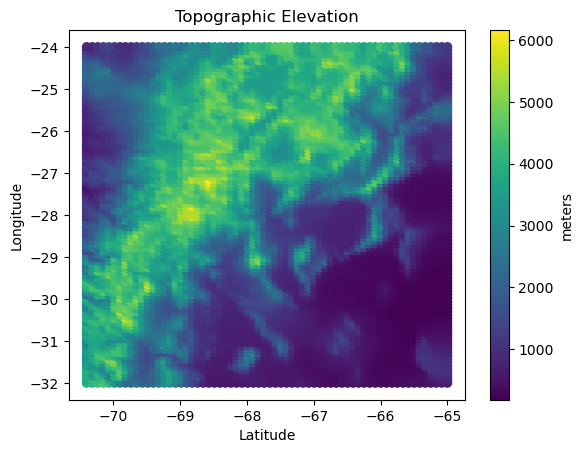

In [2]:
df_topo = pd.read_csv(
    './Topo16Enero.dat', 
    delim_whitespace=True, 
    header=None,
    skiprows=2, 
    names=['Longitude', 'Latitude', 'Elevation']
)

# Convert pandas DataFrame to xarray Dataset for analysis and visualization
ds_topo = df_topo.set_index(['Latitude', 'Longitude']).to_xarray()

# Topography visualization
plt.scatter(df_topo.Longitude, df_topo.Latitude, c=df_topo.Elevation)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar(label='meters')
plt.title('Topographic Elevation') 
plt.show()

## Set physical parameters

In [3]:
# Topography density layer in kg/m3
rho_topo = 2670
# Crust density in kg/m3
rho_crust = 2900
# Mantle density in kg/m3
rho_mantle = 3300
# Water density in kg/m3 
rho_water = 1030.0

# Average crust thickness
crust_thickness = 35000

## **Method 1:** Point-by-point isostatic geoid anomaly

**Step-by-step:** 

1. valuate normal gravity from the WGS84 reference ellipsoid at each observation point (latitude,height).
2. Call `fn.calculate_geoid_anomaly` to calcualte the isostatic geoid anomaly formula and write the result into `ds_topo["Geoid_anomaly_points"]`.
3. Plot the resulting geoid anomaly map.

In [4]:
# Calculate the normal gravity using the WGS84 model (mGal)
normal_gravity = bl.WGS84.normal_gravity(df_topo.Latitude, df_topo.Elevation) 

# # Calculate geoid anomaly using Airy's formula
geoid_anomaly_points = fn.calculate_geoid_anomaly(
    rho_topo, rho_mantle, crust_thickness, df_topo.Elevation, normal_gravity
)

# Add result to the xarray dataset
shape = ds_topo.Elevation.shape
ds_topo['Geoid_anomaly_points'] = (
    ['Latitude', 'Longitude'], np.reshape(geoid_anomaly_points, shape)
)

In [5]:
ds_topo

<xarray.Dataset>
Dimensions:               (Latitude: 100, Longitude: 66)
Coordinates:
  * Latitude              (Latitude) float64 -32.0 -31.92 ... -24.08 -24.0
  * Longitude             (Longitude) float64 -70.4 -70.32 ... -65.08 -65.0
Data variables:
    Elevation             (Latitude, Longitude) float64 3.841e+03 ... 1.164e+03
    Geoid_anomaly_points  (Latitude, Longitude) float64 19.81 21.54 ... 5.07

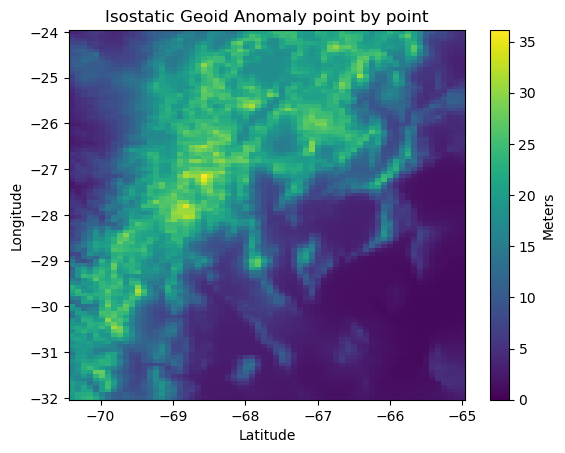

In [6]:
# Visualize the calculated anomaly
p = ds_topo.Geoid_anomaly_points.plot(vmin=0, add_colorbar=False)
plt.title("Isostatic Geoid Anomaly point by point")
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar(p, label='Meters')
plt.show()

## **Method 2:** Isostatic geoid anomaly using tesseroid model

The geoid anomaly caused by isostatic compensation also can modelling using tesseroid and calculating the gravity potential:

$$
\Delta N = -\frac{2\pi G}{g_r} \int_{-\infty}^{z_c} z \Delta \rho(z) dz = \frac{T_{topo} + T_{root}}{g_r}
$$

where $T_{topo}$ is the gravity potential produced by the topography, $T_{root}$ is the gravity potential produced by the root and $g_r$ is the normal gravity.  

**Step-by-step:**

1. Convert geodetic coordinates (longitude, latitude, height) to geocentric spherical coordinates 
    (longitude, latitude, radius). 
2. Interpolate the scattered spherical data onto a regular spherical grid using `verde.Cubic` with 0.08° spacing, 
    producing an `xarray.Dataset` called `ds_topo_sph.
    
3. Topography tesseroids:
    1. Compute the geocentric reference radius at each grid node using WGS84 ellipsoid.
    2. Assign density.
    3. Build a tesseroid layer from the surface defined by the topographic elevation (spherical coordinates) down to 
        the reference (WGS84 ellipsoid).
    4. Compute gravitational potential $T_{topo}$ and store it in `ds_topo_sph['Potential_topo']`.
    
4. Root tesseroids (Airy root):
    1. Compute the Airy root at the scattered points and grid it over the same spherical mesh, storing it in 
        `ds_topo_sph['Root']`.   
    2. Assign density contrast.
    3. Build a root tesseroid layer extending from `WGS84 - crust_thickness` (surface) down to 
        `WGS84 - crust_thickness - root` (reference).
    4. Compute gravitational potential of the model as $T_{root}$ and store it in `ds_topo_sph['Potential_root']`.
    
5. Convert spherical grid nodes back to geodetic (lat, height) to evaluate normal gravity at observation level.
6. Compute the tesseroid geoid anomaly and store as `ds_topo_sph["Geoid_anomaly_tesseroid"]` and plot. 

### Calculate the topography potential generate using tesseroid model

#### Convert geodetic coordinates to geocentric spherical coordinates

In [7]:
# Convert geodetic coordinates to geocentric spherical coordinates
lon_sph, lat_sph, ele_sph = bl.WGS84.geodetic_to_spherical(
    df_topo.Longitude.values, df_topo.Latitude.values, df_topo.Elevation.values
)

#  Interpolate elevation on spherical coordinates to obtain a regular grid
interp = vd.Cubic().fit((lon_sph, lat_sph), ele_sph)

ds_topo_sph = interp.grid(
    region=vd.get_region((lon_sph, lat_sph)), 
    spacing=0.08, 
    dims=["Latitude_sph", "Longitude_sph"],
    data_names="Elevation_sph"
)

In [8]:
ds_topo_sph

<xarray.Dataset>
Dimensions:        (Latitude_sph: 101, Longitude_sph: 69)
Coordinates:
  * Longitude_sph  (Longitude_sph) float64 -70.4 -70.32 -70.24 ... -65.08 -65.0
  * Latitude_sph   (Latitude_sph) float64 -31.83 -31.75 -31.67 ... -23.94 -23.86
Data variables:
    Elevation_sph  (Latitude_sph, Longitude_sph) float64 nan nan nan ... nan nan
Attributes:
    metadata:  Generated by Cubic()

#### Calculate the topography potential generate using tesseroid model

If the elevation is above the reference surface, assign a density value of `rho_topo`, otherwise, `rho_water - rho_crust`.

In [9]:
# # Calculate geocentric reference radius for each grid point (reference surface)
# This provides the reference elevation (bottom) of each tesseroid
coord_sph = np.meshgrid(ds_topo_sph.Longitude_sph, ds_topo_sph.Latitude_sph)
reference = bl.WGS84.geocentric_radius(coord_sph[1], geodetic=False)

# Assign densities to tesseroids based on elevation relative to reference radius
densities = np.where(
    ds_topo_sph.Elevation_sph.values >= reference, rho_topo, rho_water - rho_crust
)

# Create tesseroid model for topography
tesseroids = hm.tesseroid_layer(
    coordinates=(ds_topo_sph.Longitude_sph.values, ds_topo_sph.Latitude_sph.values),
    surface=ds_topo_sph.Elevation_sph.values,
    reference=reference,
    properties={"density": densities},
)

# Calculate the gravitational potential produced by the topography tesseroid model
potencial_topo = tesseroids.tesseroid_layer.gravity(
    (coord_sph[0], coord_sph[1], ds_topo_sph.Elevation_sph), field='potential'
)
# Add the calculated geoid to the xarray dataset
ds_topo_sph['Potential_topo'] = (['Latitude_sph', 'Longitude_sph'], potencial_topo)

### Calculate the root potential generate using tesseroid model

#### Calculate the root

In [10]:
# Calculate the root
root = fn.airy_root(rho_crust, rho_mantle, ds_topo.Elevation.values.flatten())

# Interpolate root thickness onto spherical coordinate grid
interp = vd.Cubic().fit((lon_sph, lat_sph), root)
ds_root_sph = interp.grid(
    region=vd.get_region((lon_sph, lat_sph)),
    spacing=0.08,
    dims=["latitude", "longitude"],
    data_names="root"
)
# Add to the dataset
ds_topo_sph['Root'] = (['Latitude_sph', 'Longitude_sph'], ds_root_sph.root.values)

#### Compute the potential generate from root tesseroid

If the surface is above the reference, assign a density value of `rho_mantle - rho_crust`, otherwise, `rho_crust - rho_mantle`.

In [11]:
# Define the reference as the geocentric radius minus the crustal thickness at each point.
reference = bl.WGS84.geocentric_radius(coord_sph[0], geodetic=False) - crust_thickness

# Define the surface of the tesseroid as the geocentric radius minus both the root depth and the crustal thickness. 
surface = reference - ds_topo_sph.Root.values

# Assign densities to each tesseroid.
densities = np.where(
    surface >= reference, rho_mantle - rho_crust, rho_crust - rho_mantle
)

# Create tesseroid model for the isostatic root
tesseroids = hm.tesseroid_layer(
    coordinates=(ds_topo_sph.Longitude_sph.values, ds_topo_sph.Latitude_sph.values),
    surface=surface,
    reference=reference,
    properties={"density": densities},
)

# Calculate the gravitational potential produced by the root tesseroid model
potencial_root = tesseroids.tesseroid_layer.gravity(
    (coord_sph[0], coord_sph[1], ds_topo_sph.Elevation_sph), field='potential'
)
# Add the calculated geoid to the xarray dataset
ds_topo_sph['Potential_root'] = (['Latitude_sph', 'Longitude_sph'], potencial_root)

In [12]:
ds_topo_sph

<xarray.Dataset>
Dimensions:         (Latitude_sph: 101, Longitude_sph: 69)
Coordinates:
  * Longitude_sph   (Longitude_sph) float64 -70.4 -70.32 -70.24 ... -65.08 -65.0
  * Latitude_sph    (Latitude_sph) float64 -31.83 -31.75 ... -23.94 -23.86
Data variables:
    Elevation_sph   (Latitude_sph, Longitude_sph) float64 nan nan ... nan nan
    Potential_topo  (Latitude_sph, Longitude_sph) float64 nan nan ... nan nan
    Root            (Latitude_sph, Longitude_sph) float64 nan nan ... nan nan
    Potential_root  (Latitude_sph, Longitude_sph) float64 nan nan ... nan nan
Attributes:
    metadata:  Generated by Cubic()

### Calculate the geoid anomaly

In [13]:
# Calculate the normal gravity in the same points and trasform 
coord = np.meshgrid(ds_topo_sph.Longitude_sph.values, ds_topo_sph.Latitude_sph.values)
coord = bl.WGS84.spherical_to_geodetic(
    coord[0], coord[1], ds_topo_sph.Elevation_sph.values
)

# Calculate the normal gravity
normal_gravity = bl.WGS84.normal_gravity(coord[1], coord[2]) * 1.0E-5

# Calculate and add the anoomaly in the dataset
shape = ds_topo.Geoid_anomaly_points.shape
ds_topo_sph['Geoid_anomaly_tesseroid'] = (
    ds_topo_sph.Potential_topo + ds_topo_sph.Potential_root
) / normal_gravity

## Plot results

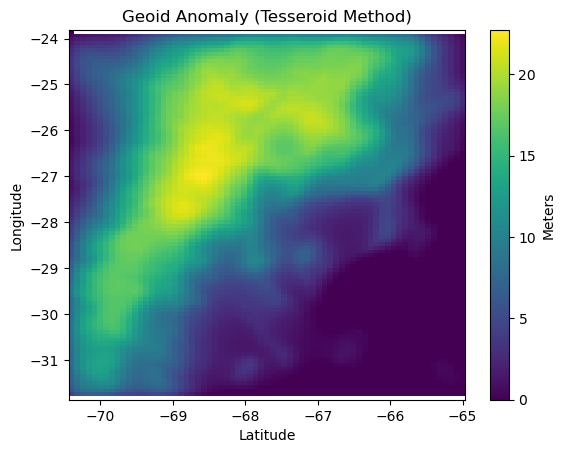

In [14]:
p = ds_topo_sph.Geoid_anomaly_tesseroid.plot(vmin=0, add_colorbar=False)
plt.title("Geoid Anomaly (Tesseroid Method)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar(p, label='Meters')
plt.show()

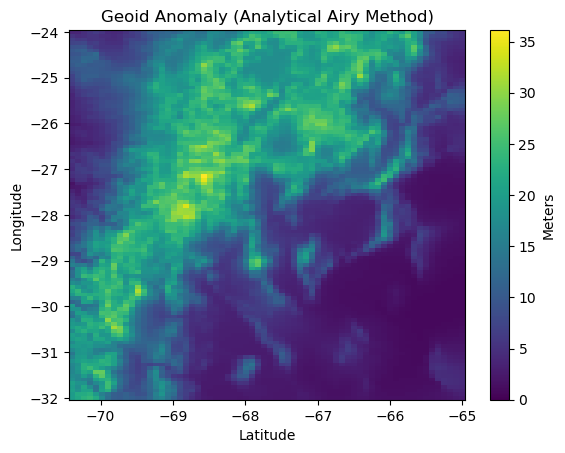

In [15]:
p = ds_topo.Geoid_anomaly_points.plot(vmin=0, add_colorbar=False)
plt.title("Geoid Anomaly (Analytical Airy Method)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar(p, label='Meters')
plt.show()